In [13]:
import os, sys
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate, KFold, learning_curve, permutation_test_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (root_mean_squared_error, 
                             r2_score, 
                             root_mean_squared_log_error, 
                             max_error, 
                             explained_variance_score,
                             median_absolute_error, 
                             d2_absolute_error_score)

from src.python_scratch.metrics import (scr_root_mean_squared_error,
                                        scr_r2_score, 
                                        scr_d2_absolute_error_score,
                                        scr_explained_variance_score,
                                        scr_max_error,
                                        scr_median_absolute_error, 
                                        scr_root_mean_squared_log_error, 
                                        scr_symmetric_mean_absolute_percentage_error)
from src.python_scratch.linear_regression import ScratchLinearRegression
from src.python_scratch.preprocessing import ScratchStandartScaler
from src.python_scratch.model_selection import scr_train_test_split

## 1. Baseline model: data sanity check

**EN**

In this section:
- I use `LinearRegression` + `StandardScaler` from sklearn.
- I run k-fold cross-validation.
- I look at RMSE and R² on train/val.
- I plot the learning curve.
- I run a permutation test to make sure the model is actually capturing signal.
- I compute RMSE and R² on the held-out test set.

---

**RU**

В этом разделе:
- Беру `LinearRegression` + `StandardScaler` из sklearn.
- Делаю k-fold кросс-валидацию.
- Смотрю на RMSE и R² на train/val.
- Строю learning curve.
- Запускаю permutation test, чтобы убедиться, что модель действительно ловит сигнал.
- Считаю RMSE и R² на отложенном test.

In [7]:
df = pd.read_csv('..\\data\\regression\\AMES_Final_DF.csv')
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
pipe = make_pipeline(
    StandardScaler(),
    LinearRegression()
)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(pipe, X_train, y_train, scoring={'rmse': 'neg_root_mean_squared_error', 'r2':'r2'}, cv=cv, verbose=0, return_train_score=True)
print(f"Среднее время затраченное на стандартизацию и обучение модели: {scores['fit_time'].mean():.5f}")
print(f"Среднее время затраченное на вычисление ошибок RMSE и R2: {scores['score_time'].mean():.5f}")
print(f"Средняя оценка RMSE на val: {-scores['test_rmse'].mean():.3f} +- {scores['test_rmse'].std():.3f}")
print(f"Средняя оценка R2 на val: {scores['test_r2'].mean():.3f} +- {scores['test_r2'].std():.3f}")
print(f"Средняя оценка RMSE | R2 на train: {-scores['train_rmse'].mean():.3f} | {scores['train_r2'].mean():.3f}")


Среднее время затраченное на стандартизацию и обучение модели: 0.09361
Среднее время затраченное на вычисление ошибок RMSE и R2: 0.00610
Средняя оценка RMSE на val: 24710.842 +- 1417.542
Средняя оценка R2 на val: 0.902 +- 0.016
Средняя оценка RMSE | R2 на train: 18914.987 | 0.944


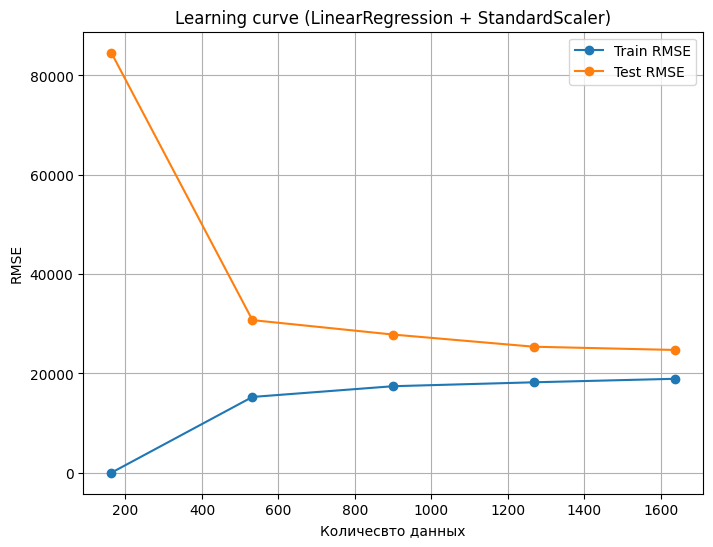

In [9]:
train_sizes, train_scores, test_scores = learning_curve(pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1)
train_scores_mean, test_scores_mean = np.mean(train_scores, axis=1), np.mean(test_scores, axis=1)
plt.figure(figsize=(8,6), dpi=100)
plt.plot(train_sizes, -train_scores_mean, marker='o', label="Train RMSE")
plt.plot(train_sizes, -test_scores_mean, marker='o', label="Test RMSE")
plt.xlabel('Количесвто данных')
plt.ylabel('RMSE')
plt.legend()
plt.title('Learning curve (LinearRegression + StandardScaler)')
plt.grid()
plt.show()

In [10]:
score, premutation_score, p_value = permutation_test_score(pipe, X_train, y_train, cv=cv, random_state=42, n_jobs=-1, scoring='r2')
print(f'Оригинальная оценка: {score:.3f}')
print(f'Оценка после перемешивания ответов: {premutation_score.mean():.3f}')
print(f'p_value: {p_value:.3f}')

Оригинальная оценка: 0.902
Оценка после перемешивания ответов: -0.236
p_value: 0.010


In [12]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
RMSE = root_mean_squared_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)
print(f'RMSE на test: {RMSE:.3f}')
print(f'R2 на test: {R2:.3f}')

RMSE на test: 21461.048
R2 на test: 0.928


## Baseline model results (LinearRegression + StandardScaler)

**EN**

- CV (5-fold, 70% train):  
  - RMSE (val): **24,710 ± 1,418**  
  - R² (val): **0.902 ± 0.016**  
  - RMSE | R² (train): **18,915 | 0.944**  
- Permutation test: R² = **0.902**, permuted ≈ **−0.236**, p-value = **0.010**  
- Test (30%): RMSE = **21,461**, R² = **0.928**

**Summary:** linear model with scaling works well (R² ≈ 0.9), shows a small train/val gap (slight overfitting), and clearly captures a real signal (low p-value). Learning curve suggests that more data still helps, but with diminishing returns.

---

**RU**

**Итог:** линейная модель со стандартизацией работает хорошо (R² ≈ 0.9), есть небольшой разрыв train/val (лёгкое переобучение), модель явно ловит сигнал (маленький p-value). Learning curve показывает, что дополнительные данные помогают, но эффект постепенно снижается.


**|━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━|**

## 2. Comparison of implementations: sklearn vs Python scratch vs C++

**EN**

At this point I have already verified that:

- my custom metrics match the results from `sklearn.metrics` (differences only at machine precision level);
- `ScratchStandardScaler` produces the same transformed features as sklearn’s `StandardScaler`;
- `scr_train_test_split` correctly reproduces the splitting logic.

Next, instead of comparing individual components in isolation, I want to compare **three complete stacks**:

1. **sklearn stack:**  
   `train_test_split` + `StandardScaler` + `LinearRegression` + metrics from `sklearn.metrics`.

2. **Python scratch stack:**  
   `scr_train_test_split` + `ScratchStandardScaler` + `ScratchLinearRegression` + my custom `scr_*` metrics.

3. **C++ stack:**  
   C++ implementations of splitting, scaling, linear regression and metrics, exposed to Python via bindings.

The main goals of this section are:

- to ensure that all three stacks produce consistent quality estimates on the same dataset;
- to compare training and inference time between sklearn, Python scratch, and C++;
- to use sklearn as a **reference implementation**, and treat the Python and C++ versions as correctness checks and a step towards a more efficient, low-level solution.

---

**RU**

На этом этапе я уже проверил, что:

- мои метрики совпадают с метриками из `sklearn.metrics` (расхождения только на уровне машинной точности);
- `ScratchStandardScaler` даёт те же результаты, что и `StandardScaler` из sklearn;
- `scr_train_test_split` корректно повторяет логику разбиения.

Дальше я хочу сравнивать **не отдельные блоки**, а **три полных стека**:

1. **sklearn-стек:**  
   `train_test_split` + `StandardScaler` + `LinearRegression` + метрики из `sklearn.metrics`.

2. **Python scratch-стек:**  
   `scr_train_test_split` + `ScratchStandardScaler` + `ScratchLinearRegression` + мои `scr_*`-метрики.

3. **C++-стек:**  
   реализация разбиения/масштабирования/линейной регрессии и метрик на C++, вызываемая из Python.

Основные задачи этого раздела:

- убедиться, что все три стека дают согласованные оценки качества на одном и том же датасете;
- сравнить время обучения и предсказаний для sklearn, Python scratch и C++;

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
RMSE = root_mean_squared_error(y_test, y_pred)
RMSE

21461.048239291147